In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from astropy.coordinates import Angle
from astropy import units as u
from astropy.coordinates import EarthLocation, AltAz, ITRS, CartesianRepresentation
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128
import itertools

In [3]:
const_c = 3e8   # speed of light [m/s]
frequency = 5e9              # observing frequency [Hz]
wavelength = const_c/frequency # receiving wavelength [metres]

# Funciones

In [4]:
#función profe
def _earthlocation_to_altaz(location, reference_location):
    itrs_cart = location.get_itrs().cartesian
    itrs_ref_cart = reference_location.get_itrs().cartesian
    local_itrs = ITRS(itrs_cart - itrs_ref_cart, location=reference_location)
    return local_itrs.transform_to(AltAz(location=reference_location))

In [5]:
#función profe
def earth_location_to_local(location, reference_location):
    altaz = _earthlocation_to_altaz(location, reference_location)
    return altaz.cartesian.xyz

In [6]:
def calc_R(H,dec):
    
    """
    function to calculate rotation matrix
    """
    
    R = [[np.sin(H), np.cos(H), 0],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec)],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec)]]
    
    return np.array(R)

In [7]:
# Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
# ángulo horario y declinación para seguir su posición en el cielo

def calc_RR(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [8]:
def h(hObs, gradDec):

    """ 
    Cambia la duración de la observación a X horas
    Muestreo cada 0.1 hrs - 6 min
       """

    observacion_grados = hObs * 15.0
    HA = np.arange(-np.radians(observacion_grados), np.radians(observacion_grados), np.radians(0.1))  # [radianes]
    dec = np.radians(gradDec)
    return HA, dec

In [9]:
#antiguo pero modifcado con nuevo pixel-uv
def grid_sampling(piximg, max_B, coverage):
    """ 
    piximg: cantidad de pixeles de la imagen modelo, tiene que ser nxn
    max_B: baseline mas largo
    uvcoverage: array uv cobertura

       """
    sampling = np.zeros((piximg, piximg)) + 1j*np.zeros((piximg, piximg))
    min_lambda=np.min(np.abs(coverage)) #minima longitud de onda lambda
    delta_x = (min_lambda / max_B) / 7
    delta_u = 1 / ((piximg * delta_x) + 0.00001)
    print("------------")
    print(delta_x)
    print(delta_u)
    print(min_lambda)
    print("------------")

    u_pixel2 = np.floor(0.5 + coverage[:, 0] / delta_u + piximg / 2).astype(int)
    v_pixel2 = np.floor(0.5 + coverage[:, 1] / delta_u + piximg / 2).astype(int)

    """ for i in range(coverage.shape[0]):
      u_pixel = int(np.floor(0.5 + coverage[i,0]/delta_u) + piximg/2)
      v_pixel = int(np.floor(0.5 + coverage[i,1]/delta_u) + piximg/2)
      uvgrid[v_pixel, u_pixel] += 1.0 + 1j*0.0 """
      
    # S(u,v) = 1 otro caso S=0
    """ sampling = np.zeros_like(uvgrid)
    posiciones_con_valores = uvgrid != 0
    sampling[posiciones_con_valores] = 1 """
    sampling[u_pixel2, v_pixel2] = 1.0
    return sampling


In [10]:
def baselines(xyz):
    #rehacer con broadcasting e indexacion
    XYZ_baselines = []                                                                  
    for i in range(len(xyz)):                                                         
        for j in range(i+1,len(xyz)):
            XYZ_baselines.append(np.subtract(xyz[i], xyz[j])) # (u,v)
            XYZ_baselines.append(np.subtract(xyz[j], xyz[i])) # (-u,-v)     

    XYZ_baselines = np.array(XYZ_baselines)
    return XYZ_baselines

In [11]:
def new_base(xyz):

    antenna_id = np.arange(0, len(xyz[:,0])) #cantidad de antenas
    antenna_pair_combinations = np.fromiter(itertools.chain(*itertools.combinations(antenna_id, 2)), dtype=int).reshape(-1,2) #combinaciones

    baselines = np.vstack([xyz[antenna_pair_combinations[:,0]] - xyz[antenna_pair_combinations[:,1]], 
                       xyz[antenna_pair_combinations[:,1]] - xyz[antenna_pair_combinations[:,0]]]) # se generan los baselines

    return baselines

In [12]:
def coverage(baselines, HA, dec):
    UV_coverage=[]
    for i in range(len(HA)):
        for j in range(len(baselines)):
            R = calc_R(HA[i],dec)
            UV_coverage.append(np.dot(R, baselines[j]))
    
    UV_coverage = np.array(UV_coverage)
    return UV_coverage

In [13]:
def new_cover(baseline, HA, dec):
    R = calc_RR(HA, dec).transpose(2,0,1)
    coverage = np.dot(R, baseline.T)/wavelength #se divide por la longitud de onda
    #transpuesta para que no sean puntos (u,v) sobre un mapa sino que se vea como dado la rotación de la tierra se van generando elipses
    #caso contrario solo serían circulos
    return coverage

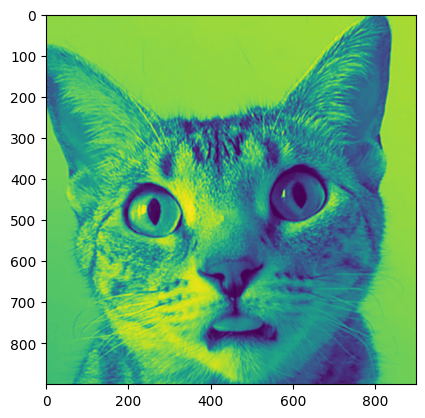

In [14]:
# Cargar la imagen como fuente de luz
image = cv2.imread('cat1.jpg',0)
plt.imshow(image)
plt.show()

In [15]:
fft = np.fft.fft2(image)
ffts = np.fft.fftshift(fft)
ff = np.abs(np.log(ffts))

# Ejemplo 1

In [16]:
data = [
    [-41.464183, -72.919694, 100],
    [-41.464507, -72.919898, 100],
    [-41.464263, -72.919739, 100],
    [-41.464304, -72.919764, 100],
    [-41.464342, -72.919789, 100],
    [-41.464387, -72.919819, 100],
    [-41.464424, -72.919843, 100],
    [-41.464469, -72.919870, 100],
    [-41.464507, -72.919898, 100]
]

df = pd.DataFrame(data, columns=['Latitud', 'Longitud', 'Altitud'])

In [17]:
abc = EarthLocation.from_geodetic(df['Latitud'], df['Longitud'], df['Altitud'])

In [18]:
reference_location = EarthLocation.from_geodetic(-41.463874, -72.920166,100)


In [19]:
# local xyz
x, y, z = earth_location_to_local(abc, reference_location)

[None, Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

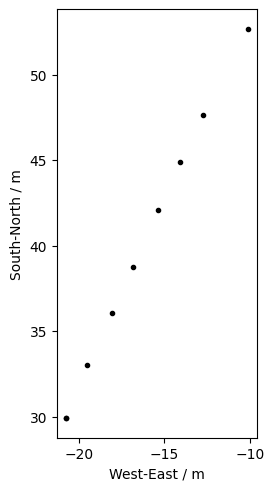

In [20]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(y, x, '.k')
ax.set(
        aspect=1,
        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [21]:
stack = np.column_stack((x.value,y.value,z.value))

In [22]:
HA, dec = h(12,20)

In [23]:
#Antiguo - me refiero a realizar la reconstrucción sin tener en cuenta los cambios de como generar el uv-coverage
UV_coverageEj1 = coverage(baselines(stack), HA, dec)/wavelength

In [24]:
#Nuevo

N_UV_coverageEJ1 = new_cover(new_base(stack), HA, dec)

Text(0, 0.5, 'v (lambda)')

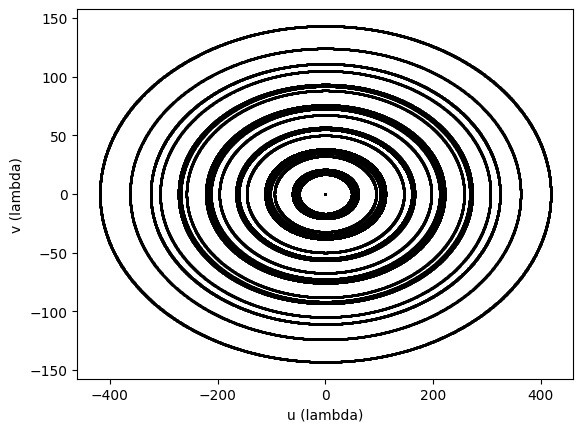

In [25]:

fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ1[:,0],N_UV_coverageEJ1[:,1], c="black", marker=".",s=1)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

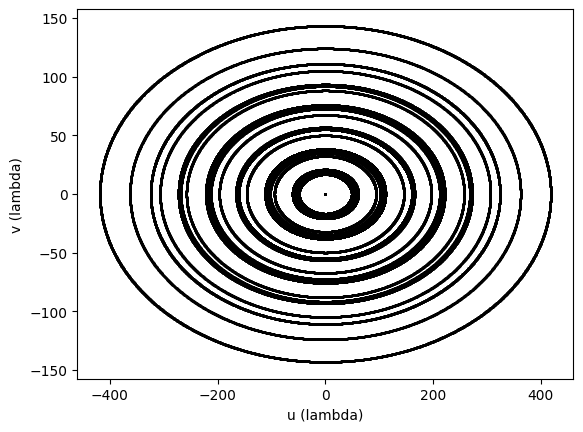

In [26]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ1.T[:, 0],N_UV_coverageEJ1.T[:,1], c="black", marker=".",s=1)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [27]:
""" plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) """

' plt.rcParams["animation.html"] = "jshtml"\nplt.rcParams[\'figure.dpi\'] = 150  \nplt.ioff()\nfig, ax = plt.subplots()\n\ndef animate(t):\n    plt.cla()\n    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")\n\nmatplotlib.animation.FuncAnimation(fig, animate, frames=len(HA)) '

In [28]:
#ocupo la misma funcion de grid y sampling para ambos
samplingEJ1=grid_sampling(900,np.max(np.abs(baselines(stack))), UV_coverageEj1)

------------
0.0
99999.99999999999
0.0
------------


In [29]:
new_samplingEJ1=grid_sampling(900,np.max(np.abs(new_base(stack))), N_UV_coverageEJ1)

------------
0.0
99999.99999999999
0.0
------------


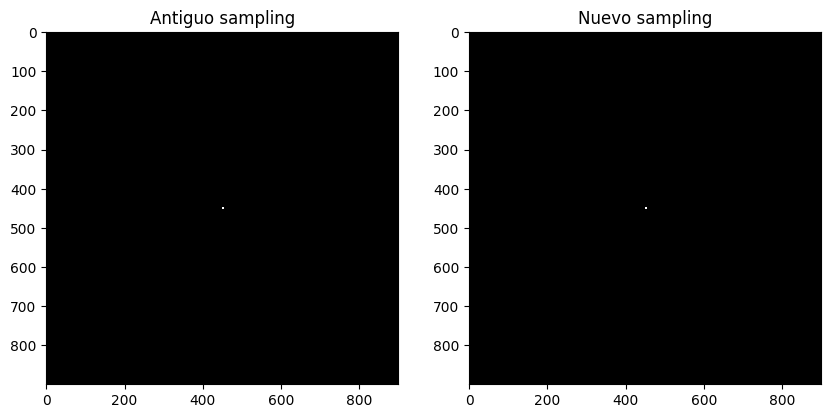

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Antiguo sampling')
plt.imshow(samplingEJ1.real, vmax=0.0005, cmap='gray')
plt.subplot(122)
plt.title('Nuevo sampling')
plt.imshow(new_samplingEJ1.real, vmax=0.0005, cmap='gray')

In [31]:
obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ1)))

In [32]:
new_obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ1)))

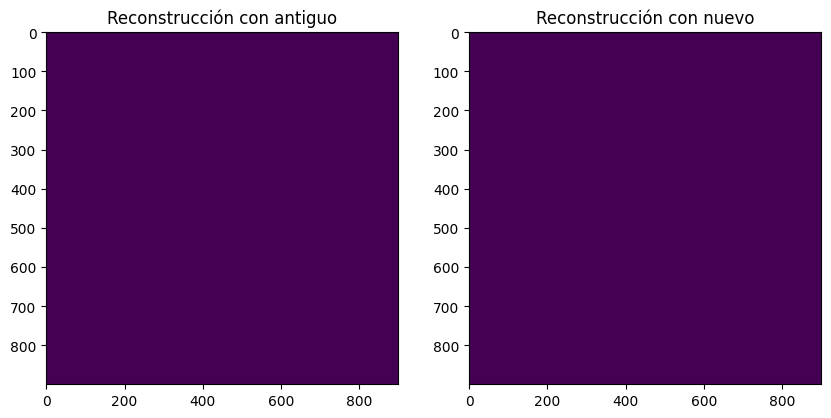

In [33]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ1)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ1)

In [34]:
# 12 horas de observación
HA, dec = h(12,45)
UV_coverageEj1 = coverage(baselines(stack), HA, dec)/wavelength
N_UV_coverageEJ1 = new_cover(new_base(stack), HA, dec)

Text(0, 0.5, 'v (lambda)')

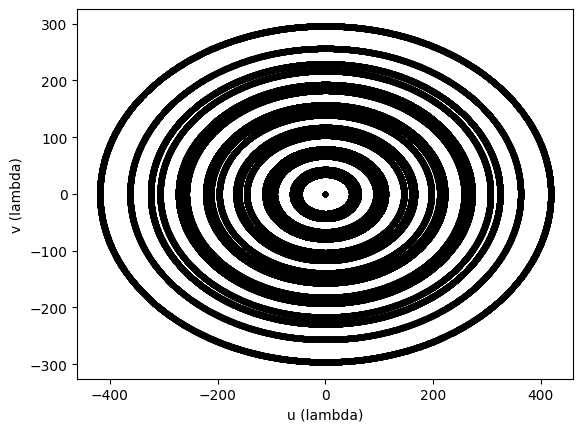

In [35]:
fig, ax = plt.subplots()
ax.scatter(UV_coverageEj1[:, 0],UV_coverageEj1[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

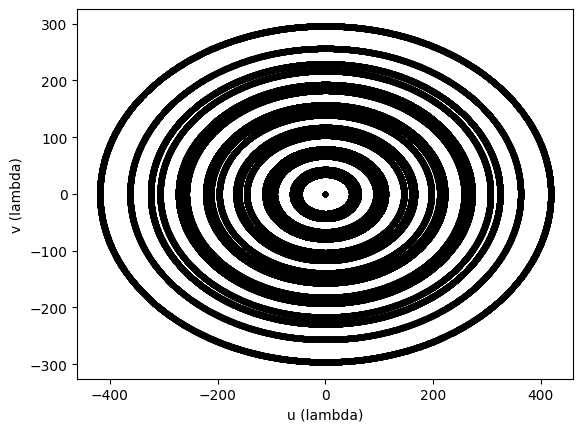

In [36]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ1[:, 0],N_UV_coverageEJ1[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [37]:
samplingEJ1=grid_sampling(900,np.max(np.abs(baselines(stack))), UV_coverageEj1)
new_samplingEJ1=grid_sampling(900,np.max(np.abs(new_base(stack))), N_UV_coverageEJ1)

------------
0.0
99999.99999999999
0.0
------------
------------
0.0
99999.99999999999
0.0
------------


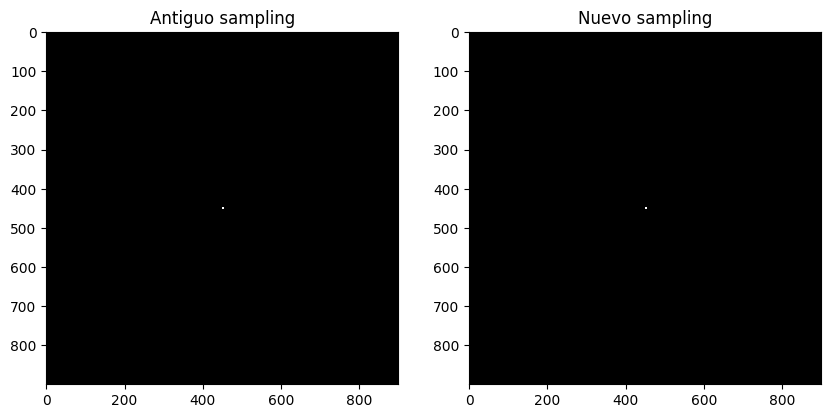

In [38]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Antiguo sampling')
plt.imshow(samplingEJ1.real, vmax=0.0005, cmap='gray')
plt.subplot(122)
plt.title('Nuevo sampling')
plt.imshow(new_samplingEJ1.real, vmax=0.0005, cmap='gray')

In [39]:
obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ1)))
new_obs_EJ1 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ1)))

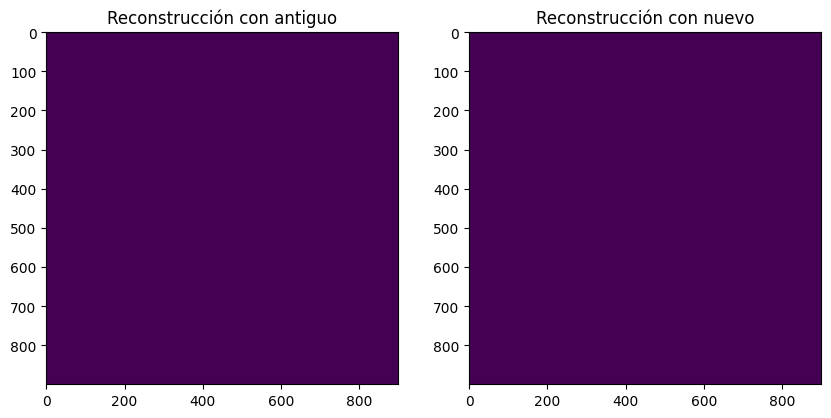

In [40]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ1)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ1)

# Ejemplo 2

In [41]:
posiciones = [
    (-41.483775, -72.859583, 100),
    (-41.482888, -72.859582, 100),
    (-41.481990, -72.859598, 100),
    (-41.481093, -72.859625, 100),
    (-41.480198, -72.859611, 100),
    (-41.484689, -72.860797, 100),
    (-41.484683, -72.861984, 100),
    (-41.484678, -72.863175, 100),
    (-41.484657, -72.864401, 100),
    (-41.484642, -72.865588, 100),
    (-41.485612, -72.859579, 100),
    (-41.486489, -72.859579, 100),
    (-41.487352, -72.859580, 100),
    (-41.488257, -72.859578, 100),
    (-41.489204, -72.859560, 100),
    (-41.484684, -72.858503, 100),
    (-41.484679, -72.857282, 100),
    (-41.484662, -72.856079, 100),
    (-41.484644, -72.854922, 100),
    (-41.484623, -72.853653, 100)
]
data = np.array(posiciones)
df = pd.DataFrame(data, columns=['Latitud', 'Longitud', 'Altitud'])
reference = [-41.484687, -72.859583]

In [42]:
abc = EarthLocation.from_geodetic(df['Latitud'], df['Longitud'], df['Altitud'])

In [43]:
reference_location = EarthLocation.from_geodetic(reference[0], reference[1], 100)

In [44]:
x, y, z = earth_location_to_local(abc, reference_location)

[Text(0.5, 0, 'West-East / m'), Text(0, 0.5, 'South-North / m')]

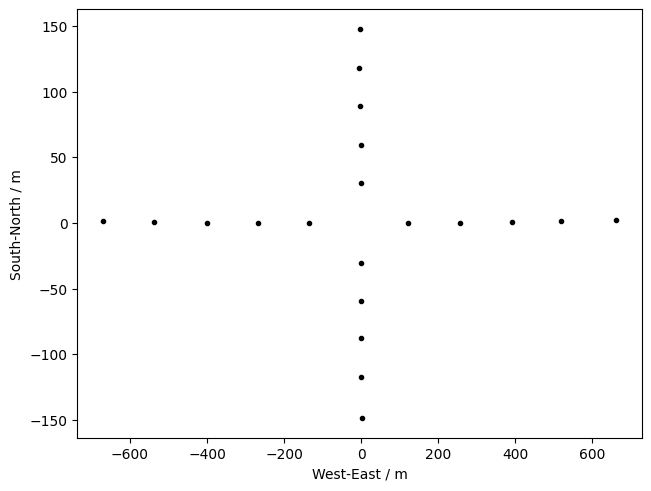

In [45]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(x, y, '.k')
ax.set(

        xlabel='West-East / m',
        ylabel='South-North / m'
)

In [46]:
ej2 = np.column_stack((x.value,y.value,z.value))

In [47]:
# 12 horas de observación
HA, dec = h(12,45)
UV_coverageEJ2 = coverage(baselines(ej2), HA, dec)/wavelength
N_UV_coverageEJ2 = new_cover(new_base(ej2), HA, dec)

Text(0, 0.5, 'v (lambda)')

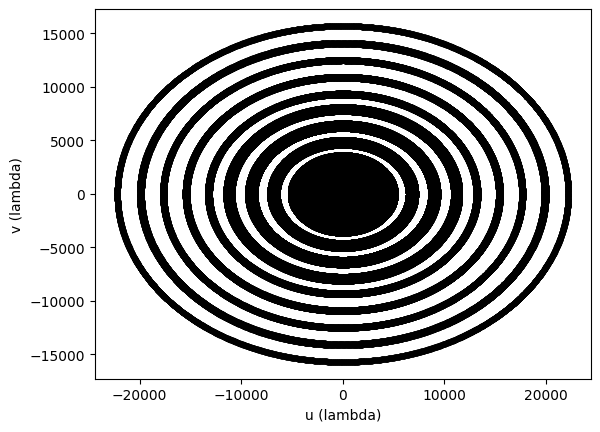

In [48]:
fig, ax = plt.subplots()
ax.scatter(UV_coverageEJ2[:, 0],UV_coverageEJ2[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

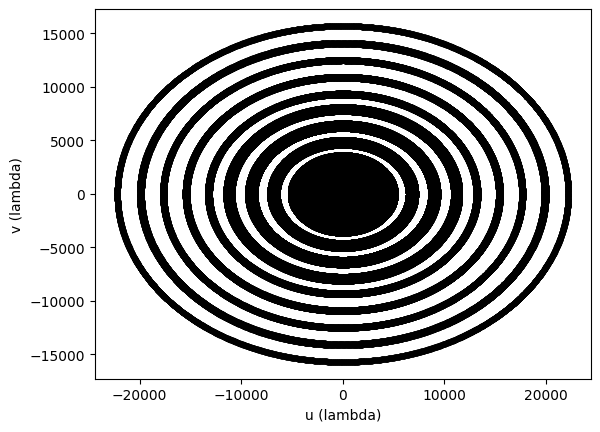

In [49]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ2[:, 0],N_UV_coverageEJ2[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [50]:
samplingEJ2=grid_sampling(900,np.max(np.abs(baselines(ej2))), UV_coverageEJ2)
new_samplingEJ2=grid_sampling(900,np.max(np.abs(new_base(ej2))), N_UV_coverageEJ2)

------------
1.3615170217240594e-08
44936.44217487271
0.0001269401108928265
------------
------------
1.36151702081437e-08
44936.442191404996
0.00012694011080801224
------------


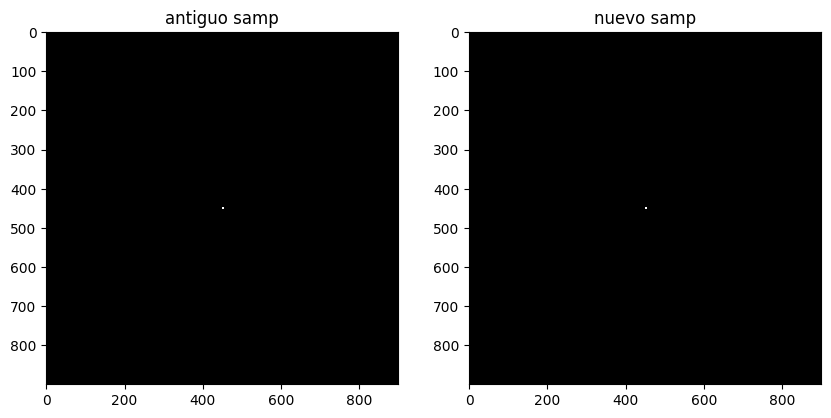

In [51]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('antiguo samp')
plt.imshow(samplingEJ2.real, cmap='gray', vmax=0.0005)
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ2.real, cmap='gray',vmax=0.0005)

In [52]:
obs_EJ2 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ2)))
new_obs_EJ2 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ2)))

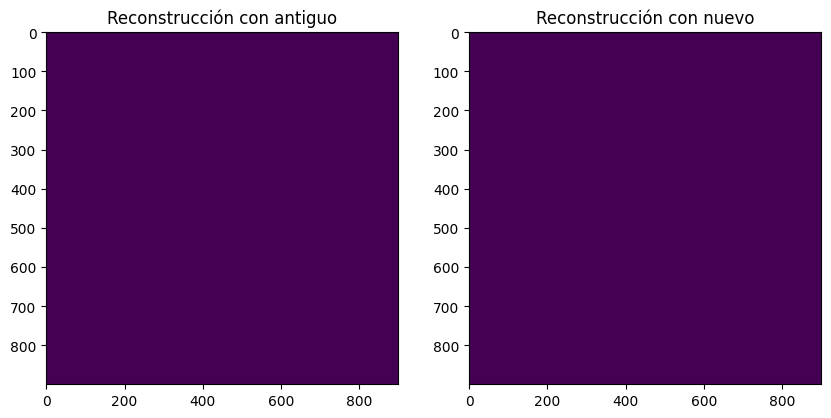

In [53]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ2)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ2)

# Ejemplo 3 VLA-D

Formas del UV-Coverage de acuerdo al siguiente PDF pag 84:
https://library.nrao.edu/public/collection/02000000000324.pdf

In [54]:
vla_north = pd.read_csv('VLA_North.csv')
vla_swest = pd.read_csv('VLA_SWest.csv')
vla_seast = pd.read_csv('VLA_SEast.csv')

In [55]:
W = 1e-9*const_c*np.array(vla_swest) #se pasa a metros
E = 1e-9*const_c*np.array(vla_seast)
N = 1e-9*const_c*np.array(vla_north)

In [56]:
eje3=np.vstack((W,N,E))

In [57]:
# 12 horas observacion dec:45
HA, dec = h(12,45)
UV_coverageEJ3 = coverage(baselines(eje3), HA, dec)/wavelength
N_UV_coverageEJ3 = new_cover(new_base(eje3), HA, dec)

Text(0, 0.5, 'v (lambda)')

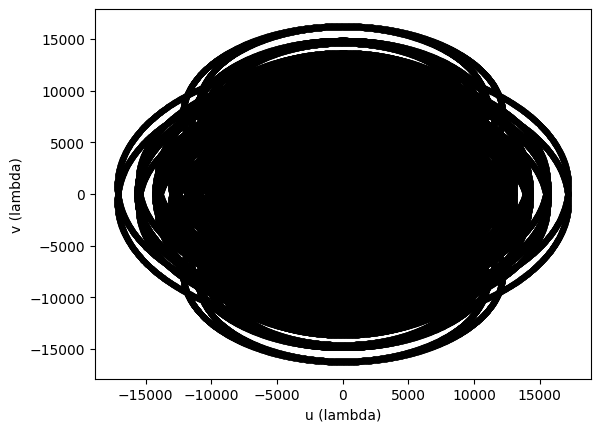

In [58]:
fig, ax = plt.subplots()

ax.scatter(UV_coverageEJ3[:, 0],UV_coverageEJ3[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)')
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

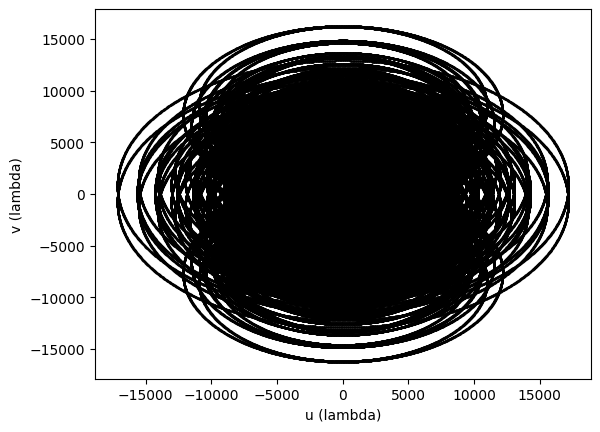

In [59]:
fig, ax = plt.subplots()
ax.scatter(N_UV_coverageEJ3[:, 0],N_UV_coverageEJ3[:,1], c="black", marker=".",s=1)
ax.set_xlabel('u (lambda)') 
ax.set_ylabel('v (lambda)')

In [60]:
samplingEJ3=grid_sampling(900,np.max(np.abs(baselines(eje3))), UV_coverageEJ3)
new_samplingEJ3=grid_sampling(900,np.max(np.abs(new_base(eje3))), N_UV_coverageEJ3)

------------
6.697642184936648e-07
1631.8862834346955
0.004823017681339739
------------
------------
6.697642183965463e-07
1631.8862836674639
0.0048230176806403815
------------


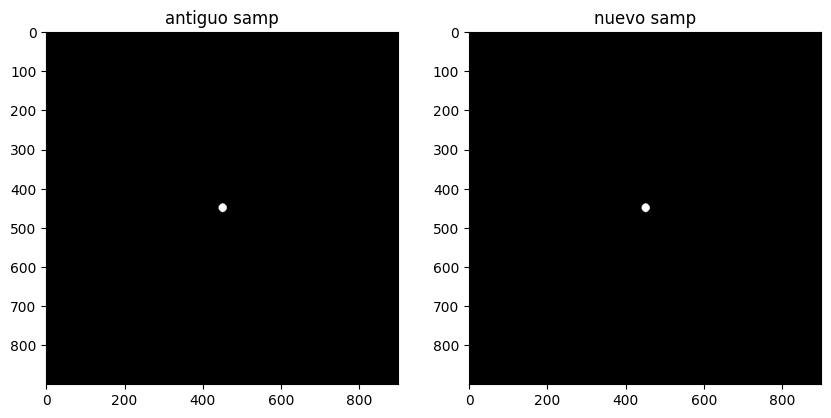

In [61]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('antiguo samp')
plt.imshow(samplingEJ3.real, cmap='gray')
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ3.real, cmap='gray')

In [62]:
obs_EJ3 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ3)))
new_obs_EJ3 = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ3)))

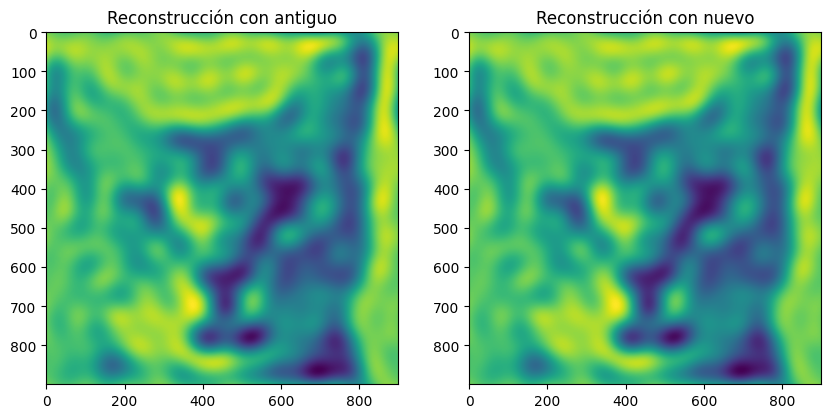

In [63]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ3)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ3)

In [64]:
# 12 horas observacion dec:20
HA, dec = h(12,20)
UV_coverageEJ3A = coverage(baselines(eje3), HA, dec)/wavelength
N_UV_coverageEJ3A = new_cover(new_base(eje3), HA, dec)

Text(0, 0.5, 'v (lambda)')

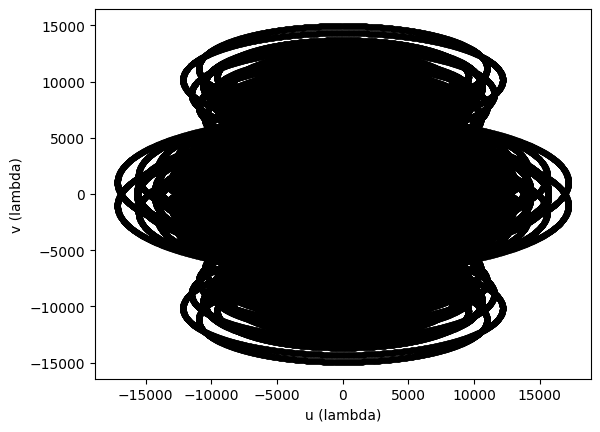

In [65]:
fig, ax = plt.subplots()

ax.scatter(UV_coverageEJ3A[:, 0],UV_coverageEJ3A[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)')
ax.set_ylabel('v (lambda)')

Text(0, 0.5, 'v (lambda)')

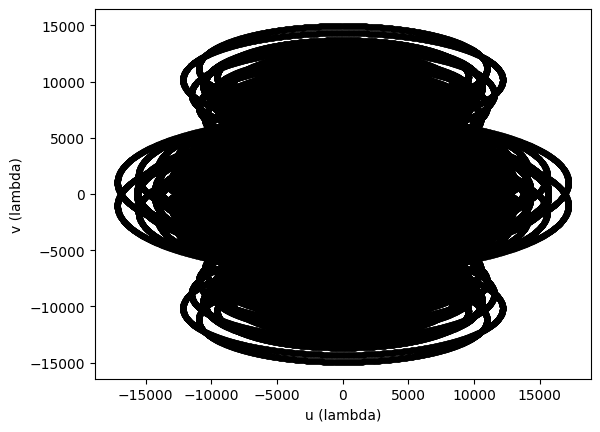

In [66]:
fig, ax = plt.subplots()

ax.scatter(N_UV_coverageEJ3A[:, 0],N_UV_coverageEJ3A[:,1], c="black", marker=".")
ax.set_xlabel('u (lambda)')
ax.set_ylabel('v (lambda)')

In [67]:
samplingEJ3A=grid_sampling(900,np.max(np.abs(baselines(eje3))), UV_coverageEJ3A)
new_samplingEJ3A=grid_sampling(900,np.max(np.abs(new_base(eje3))), N_UV_coverageEJ3A)

------------
4.62448192758091e-09
70611.32735061311
3.3301208825281217e-05
------------
------------
4.624481938171991e-09
70611.32730308708
3.330120890154831e-05
------------


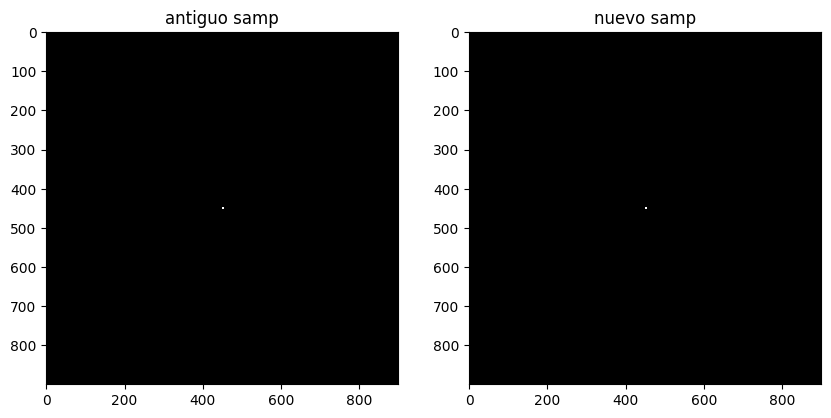

In [68]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('antiguo samp')
plt.imshow(samplingEJ3A.real, cmap='gray',vmax=0.001)
plt.subplot(122)
plt.title('nuevo samp')
plt.imshow(new_samplingEJ3A.real, cmap='gray',vmax=0.001)

In [69]:
obs_EJ3A = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*samplingEJ3A)))
new_obs_EJ3A = np.abs(np.fft.ifft2(np.fft.ifftshift(ffts*new_samplingEJ3A)))

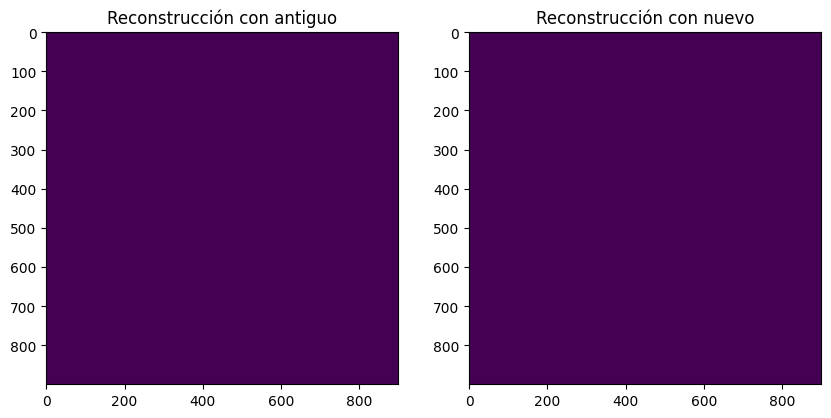

In [70]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Reconstrucción con antiguo')
plt.imshow(obs_EJ3A)
plt.subplot(122)
plt.title('Reconstrucción con nuevo')
plt.imshow(new_obs_EJ3A)

In [71]:


""" 
Para esta configración de antenas encontre que el simulador friendlyVRI igual lo posee
entonces hice comparaciones y me di cuenta que tiene delimitado el uvmax a aprox 206.000lambda
pero, en este simulador realizan el uv-coverage de manera distinta y por lo que comprendi utilizan
el uvmax a modo de escala para que el uv-coverage logre estar dentro del limite establecido.
En la carpeta hay imagenes que saque con dec=45; HA=-1 a 1

Repositorios interasantes que encontre:

https://github.com/ratt-ru/fundamentals_of_interferometry/tree/21d7754b273373adf161306f34aa920506d766a5


 """

' \nPara esta configración de antenas encontre que el simulador friendlyVRI igual lo posee\nentonces hice comparaciones y me di cuenta que tiene delimitado el uvmax a aprox 206.000lambda\npero, en este simulador realizan el uv-coverage de manera distinta y por lo que comprendi utilizan\nel uvmax a modo de escala para que el uv-coverage logre estar dentro del limite establecido.\nEn la carpeta hay imagenes que saque con dec=45; HA=-1 a 1\n\nRepositorios interasantes que encontre:\n\nhttps://github.com/ratt-ru/fundamentals_of_interferometry/tree/21d7754b273373adf161306f34aa920506d766a5\n\n\n '